In [1]:
from pathlib import Path
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

idx = pd.IndexSlice

# Define automatic naming format from file_paths
def get_name(file_path):
    name = file_path.stem.split("_")
    name = name[3]+'_'+name[4]
    return name

# Define axis labels based on parameter
def gen_param_label(param):
    param_dict = {
        'mAh':'[mAh]',
        'mass':'[mAh/g]',
        'areal':r'$\mathrm{[mAh/cm^2]}$',
        'volume':r'$\mathrm{[mAh/cm^3]$'}
    
    return param_dict[param]

In [3]:
# Open file dialog
root = Tk()
root.attributes("-topmost", True)
root.withdraw()  # stops root window from appearing
file_paths = askopenfilenames(title="Select files",
                              filetypes=[("Comma-separated values", "*.csv")])  # "Open" dialog box and return the selected path

# Convert filepaths to pathlib format
filez = []
for file in file_paths:
    file = Path(file)
    filez.append(file)
    
file_paths = filez

In [4]:
# Generate 'names' and 'param' dictionaries from file_paths
# read_csv to dataframe
names={}
params = {}
df=[]
for i, file_path in enumerate(file_paths):
    name = get_name(file_paths[i])
    names[i] = name
    
    df_imp = pd.read_csv(file_paths[i],header=[0,1],index_col=[0,1])
    df_imp = pd.concat([df_imp], axis=0, keys=[i], names=['cell'])
    
    df.append(df_imp)

    params[i] = df_imp.columns.get_level_values(0)[3]
      
df = pd.concat(df, axis=0)
df.sort_index(inplace=True)

for cell in names:
    print(cell, '->', names[cell], '->', params[cell])

0 -> OX_201214 -> mass


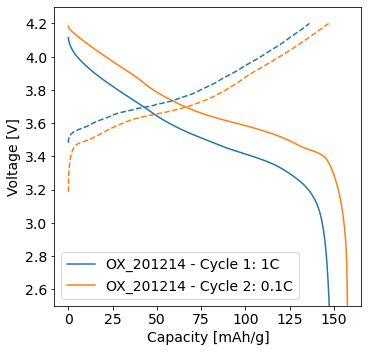

In [30]:
# Make list of cycles to plot
#cycles = df.index.unique(level=1).tolist()
pos_steps = [1,6]
pos_steps_CV = [2,7]
neg_steps = [4,9]

# Font size
plt.rcParams.update({'font.size': 14})

for cell in names:
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    
    # Params
    ax.set_ylim(ymin=2.5, ymax=4.3)

    # Create colormap
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    plt.gca().set_prop_cycle(plt.cycler('color', colors))

    # Plot for all cells
    for cycle,step in enumerate(neg_steps):
        x = df.loc[idx[cell,step,'neg'],idx['mass','n_cap']]
        y = df.loc[idx[cell,step,'neg'],idx['univ','voltage']]
        plt.plot(x, y, label = names[cell]+' - Cycle '+str(cycle+1))

    plt.gca().set_prop_cycle(plt.cycler('color', colors))

    for cycle,step in enumerate(pos_steps):
        x = df.loc[idx[cell,step,'pos'],idx['mass','p_cap']]
        y = df.loc[idx[cell,step,'pos'],idx['univ','voltage']]
        plt.plot(x, y, linestyle='dashed', label='_nolegend_')

    plt.xlabel('Capacity '+gen_param_label(params[0]))
    plt.ylabel('Voltage [V]')
    leg = plt.legend('best')
    handle, label = plt.gca().get_legend_handles_labels()
    
    leg.get_texts()[0].set_text(label[0] + ': 1C')
    leg.get_texts()[1].set_text(label[1] + ': 0.1C')

    plt.savefig(file_paths[cell].parent.joinpath('{}_{}.svg'.format('voltage_mass',names[cell])),
                format='svg',
                dpi=600,
                bbox_inches = 'tight')
    plt.show()